In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
from brian2.units import *
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import matplotlib as mlib
mlib.rcParams.update({'font.size': 22})
mlib.rcParams.update({'errorbar.capsize': 3})

In [3]:
!pwd

/c/WinPython-64bit-2.7.9.4/notebooks


In [4]:
# files = !cd case_1_lesioned_600k & ls *.txt
files =  !ls *.txt
print files

['0_1_10.txt', '0_1_11.txt', '0_1_12.txt', '0_1_2.txt', '0_1_3.txt', '0_1_4.txt', '0_1_5.txt', '0_1_6.txt', '0_1_7.txt', '0_1_8.txt', '0_1_9.txt']


In [5]:
open_files = []
eof = []
for f in files:
    open_files.append(open(f, "r"))  
    eof.append(False)
print len(open_files), "files"

11 files


In [6]:
post_ids = []
pre_app_pops = []
pre_subpops = []
pre_ids = []

global_pre_id = []
global_post_id = []
distance_sq = []

elim_prob = []
removals = []
form_prob = []
formations = []

rem_fails = []
form_fails = []

files_based_removals = {}
files_based_formations = {}

sr_attempts = []
oob= []
dist_sq_control = []

errors = {}

col_offset = []

In [7]:
for i in range(len(open_files)):
    files_based_removals[i] = []
    files_based_formations[i] = []
    for line in open_files[i]:
        if not line:
            eof[i] = True
        spleet = str.split(line)
        if "presynaptic subpopulation" in line:
            post_ids.append(int(spleet[4]))
            pre_app_pops.append(int(spleet[6]))
            pre_subpops.append(int(spleet[9]))
            pre_ids.append(int(spleet[-1]))
        elif "g_distance_sq" in line:
            global_pre_id.append(int(spleet[4]))
            global_post_id.append(int(spleet[6]))
            distance_sq.append(int(spleet[8]))
            dist_sq_control.append([int(spleet[8]), int(spleet[-1])])
        elif "elim_prob" in line:
            elim_prob.append([int(spleet[5]), int(spleet[-1])])
        elif "form_prob" in line:
            form_prob.append([int(spleet[4]), int(spleet[7]), int(spleet[9])])
        elif "| RM pre" in line:
            removals.append([int(spleet[6]), int(spleet[8]), int(spleet[13]), int(spleet[-1])])
        elif "| FORM pre" in line:
            formations.append([int(spleet[6]), int(spleet[8]), int(spleet[15]), int(spleet[-1])])
        elif "| FAIL POT" in line or "| FAIL DEP" in line: 
            rem_fails.append(int(spleet[-1]))
            files_based_removals[i].append(int(spleet[-1]))
        elif "| NO FORM" in line:
            form_fails.append(int(spleet[-1]))
            files_based_formations[i].append(int(spleet[-1]))
        elif "sr_attempt" in line:
            sr_attempts.append([int(spleet[4]), int(spleet[5]), int(spleet[7])])  
        elif "col_off" in line:
            col_offset.append([int(spleet[4])])
        
        if "| OOB" in line:
            oob.append([int(spleet[5]), int(spleet[6]), int(spleet[7])])
            form_fails.append(int(spleet[6]))
            
        if "ERROR" in line:
            if len(sr_attempts)> 0:
                if line not in errors:
                        errors[line] = [sr_attempts[-1][0]]
                else:
                        errors[line].append(sr_attempts[-1][0])
            else:
                if line not in errors:
                        errors[line] = 1
                else:
                        errors[line] += 1

In [8]:
for f in open_files:
    f.close()

In [9]:
# errors

sr_attempts = np.asarray(sr_attempts)
sr_attempts.shape

(0L,)

In [10]:
post_ids = np.asarray(post_ids)
pre_app_pops = np.asarray(pre_app_pops)
pre_subpops = np.asarray(pre_subpops)
pre_ids = np.asarray(pre_ids)

global_pre_id = np.asarray(global_pre_id)
global_post_id = np.asarray(global_post_id)
distance_sq = np.asarray(distance_sq)

rem_fails = np.asarray(rem_fails)
form_fails = np.asarray(form_fails)
sr_attempts = np.asarray(sr_attempts)

oob=np.asarray(oob)
dist_sq_control=np.asarray(dist_sq_control)

elim_prob = np.asarray(elim_prob)
col_offset = np.asarray(col_offset)

In [11]:
formations = np.asarray(formations)
removals = np.asarray(removals)
sr_attempts = np.asarray(sr_attempts)

In [12]:
def distance(x0, x1, grid=np.asarray([16, 16]), type='euclidian'):
    x0 = np.asarray(x0)
    x1 = np.asarray(x1)
    delta = np.abs(x0 - x1)
    delta = np.where(delta > grid * .5, delta - grid, delta)

    if type == 'manhattan':
        return np.abs(delta).sum(axis=-1)
    return np.sqrt((delta ** 2).sum(axis=-1))
def index_to_dist(i1, i2, grid):
    return distance((i1//grid[0], i1%grid[1]),(i2//grid[0], i2%grid[1]), grid=grid, type='euclidian')

In [13]:
layer_size = 256
grid_layout = np.asarray((16, 16))

In [14]:
for i in np.arange(global_post_id.size):
    assert np.round(index_to_dist(global_pre_id[i], global_post_id[i], grid_layout)**2) == distance_sq[i], \
    "{} vs {}".format(np.round(index_to_dist(global_pre_id[i], global_post_id[i], grid_layout)**2),  distance_sq[i])

In [15]:
counts = np.ones((layer_size, layer_size)) * np.nan

In [16]:
for i in np.arange(global_post_id.size):
    if np.isnan(counts[global_pre_id[i], global_post_id[i]]):
        counts[global_pre_id[i], global_post_id[i]] = 1
    else:
        counts[global_pre_id[i], global_post_id[i]] += 1

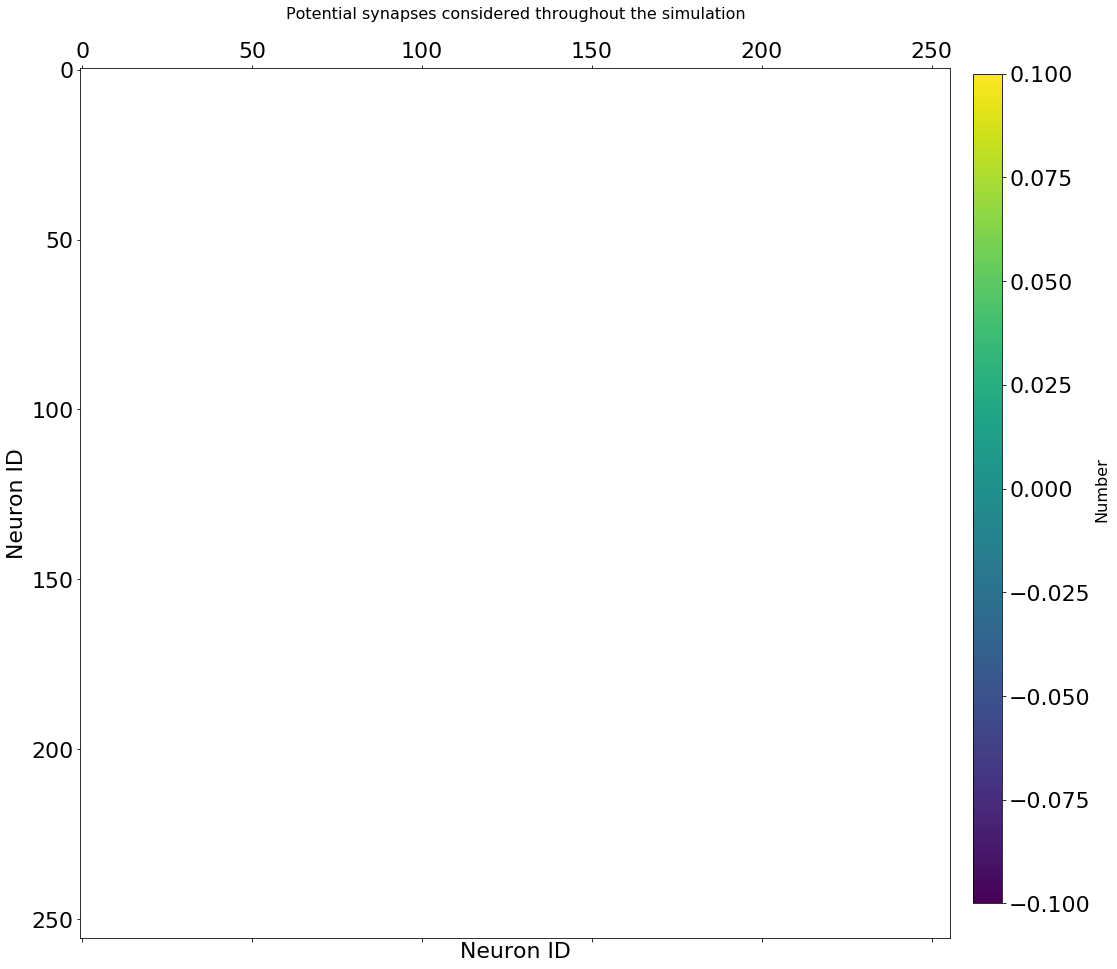

In [17]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16,16))
i = ax1.matshow(counts, vmin=0)
ax1.grid(visible=False)
ax1.set_title("Potential synapses considered throughout the simulation", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
# ax1.set_ylim([20, 0])
# ax1.set_xlim([0, 20])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("Number")
plt.savefig("global_mentions_16x16.png")

In [18]:
print "total rewire attempts", np.nansum(counts)

total rewire attempts 0.0


In [19]:
print "hit locations", np.count_nonzero(np.isfinite(counts))

hit locations 0


In [20]:
print "surface coverage", np.count_nonzero(np.isfinite(counts)) * 100. / counts.size 

surface coverage 0.0


In [21]:
elim_prob = np.asarray(elim_prob)
removals= np.asarray(removals)
form_prob= np.asarray(form_prob)
formations = np.asarray(formations)

In [22]:
formation_counts = np.ones((layer_size, layer_size)) * np.nan
for i in np.arange(formations.shape[0]):
    if np.isnan(formation_counts[formations[i, 0], formations[i, 1]]):
        formation_counts[formations[i, 0], formations[i, 1]] = 1
    else:
        formation_counts[formations[i, 0], formations[i, 1]] += 1

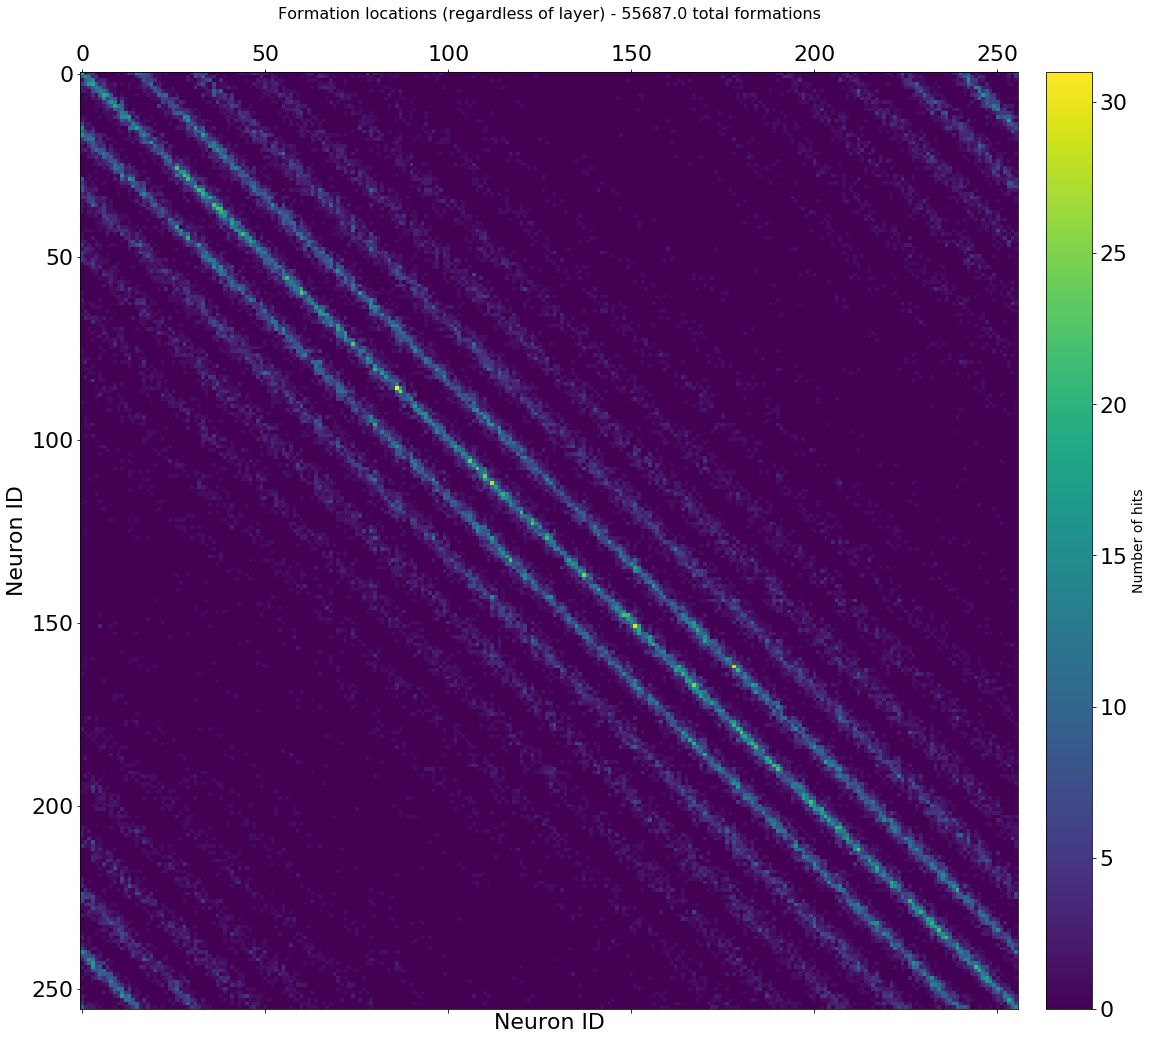

In [23]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16,16), dpi=400)
i = ax1.matshow(np.nan_to_num(formation_counts), vmin=0)
ax1.grid(visible=False)
ax1.set_title("Formation locations (regardless of layer) - " 
              + str(np.sum(formation_counts[np.isfinite(formation_counts)])) 
              + " total formations")
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
# cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
# ax1.set_ylim([20, 0])
# ax1.set_xlim([0, 20])
# cbar = f.colorbar(i, cax=cbar_ax)
# cbar.set_label("Number of hits", fontsize=16)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i, cax=cax)
cbar.set_label("Number of hits")
plt.tight_layout(.3)

plt.savefig("form_hits.png")

In [24]:
total_formations = np.sum(formation_counts[np.isfinite(formation_counts)])
print "Total number of formations", total_formations

Total number of formations 55687.0


In [25]:
np.sum(np.isfinite(formation_counts))

19452

In [26]:
deletion_counts = np.ones((layer_size, layer_size)) * np.nan
for i in np.arange(removals.shape[0]):
    if np.isnan(deletion_counts[removals[i, 0], removals[i, 1]]):
        deletion_counts[removals[i, 0], removals[i, 1]] = 1
    else:
        deletion_counts[removals[i, 0], removals[i, 1]] += 1

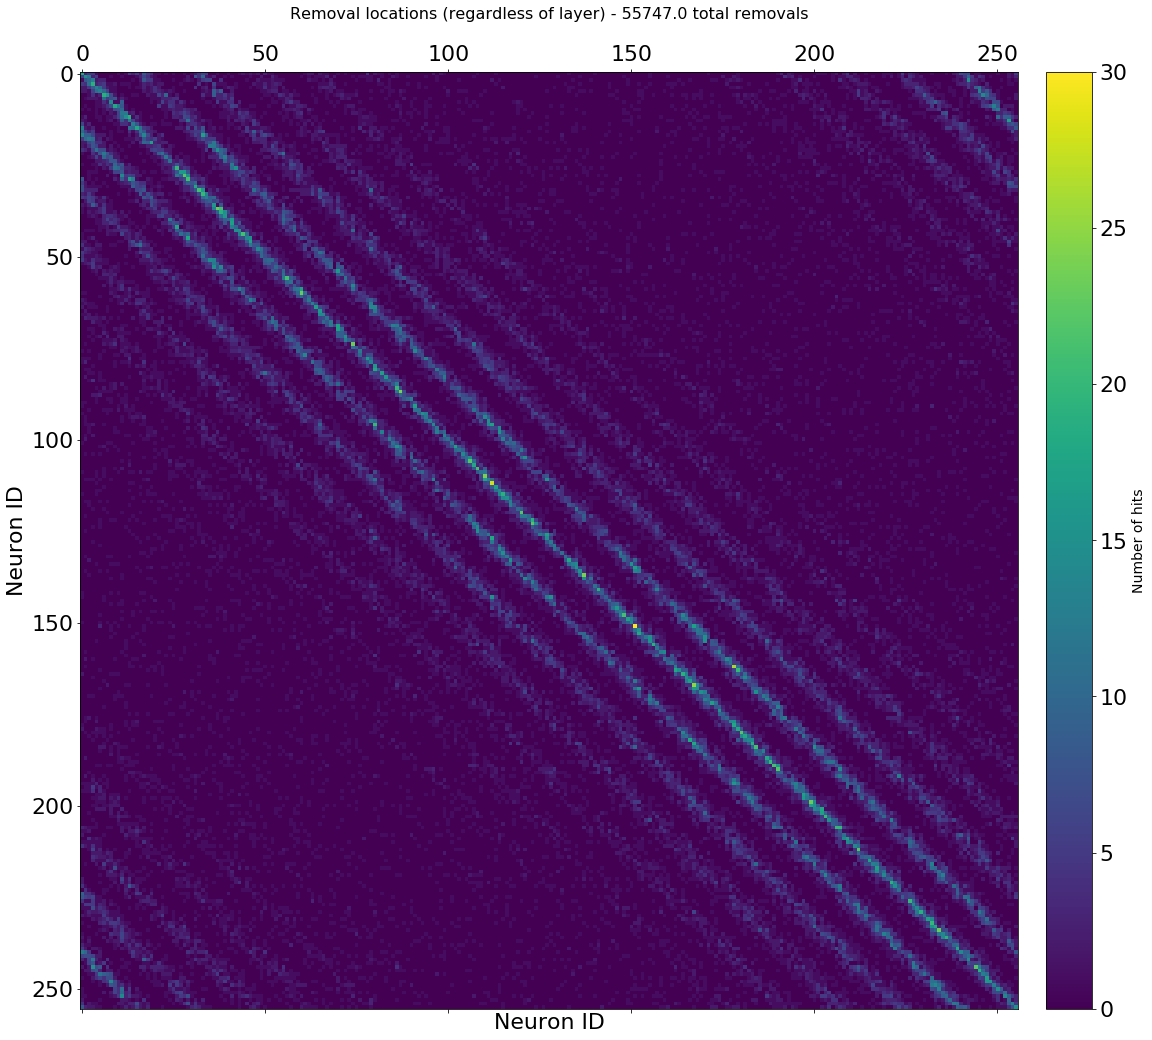

In [27]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16,16), dpi=400)
i = ax1.matshow(np.nan_to_num(deletion_counts), vmin=0)
ax1.grid(visible=False)
ax1.set_title("Removal locations (regardless of layer) - " 
              + str(np.sum(deletion_counts[np.isfinite(deletion_counts)])) 
              + " total removals" )
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i, cax=cax)
cbar.set_label("Number of hits")
plt.tight_layout(.3)
plt.savefig("removal_hits.png")

In [28]:
total_removals = np.sum(deletion_counts[np.isfinite(deletion_counts)])
print "Total number of removals", total_removals

Total number of removals 55747.0


In [29]:
np.argmax(deletion_counts[np.isfinite(deletion_counts)])

13951

(array([ 563.,  474.,  450.,  462.,  470.,  487.,  437.,  459.,  466.,
         456.,  478.,  481.,  475.,  455.,  479.,  440.,  462.,  480.,
         507.,  457.,  480.,  495.,  459.,  500.,  466.,  479.,  501.,
         474.,  501.,  490.,  495.,  486.,  508.,  522.,  549.,  523.,
         546.,  560.,  523.,  545.,  570.,  598.,  518.,  568.,  554.,
         601.,  556.,  578.,  579.,  572.,  586.,  611.,  601.,  633.,
         609.,  624.,  627.,  636.,  627.,  623.,  591.,  560.,  611.,
         586.,  656.,  589.,  593.,  611.,  561.,  559.,  615.,  612.,
         629.,  646.,  589.,  607.,  627.,  580.,  637.,  621.,  600.,
         630.,  610.,  639.,  571.,  637.,  614.,  627.,  614.,  581.,
         616.,  581.,  599.,  602.,  605.,  633.,  634.,  591.,  596.,  616.]),
 array([  1.11000000e+02,   1.21098600e+04,   2.41087200e+04,
          3.61075800e+04,   4.81064400e+04,   6.01053000e+04,
          7.21041600e+04,   8.41030200e+04,   9.61018800e+04,
          1.08100740e+05

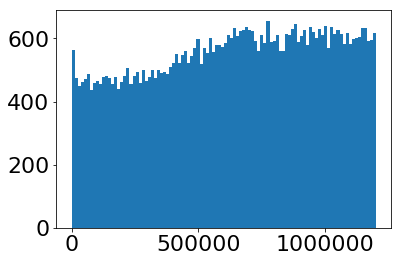

In [30]:
plt.hist(formations[:, -1], 3000000/30000)

(array([ 25.,  26.,  27.,  25.,  27.,  33.,  28.,  28.,  47.,  34.,  26.,
         32.,  34.,  34.,  33.,  42.,  40.,  53.,  51.,  43.,  33.,  58.,
         46.,  41.,  37.,  48.,  43.,  58.,  46.,  49.,  50.,  41.,  44.,
         34.,  50.,  40.,  53.,  56.,  37.,  60.,  42.,  49.,  52.,  47.,
         54.,  42.,  50.,  47.,  48.,  46.,  51.,  35.,  47.,  54.,  59.,
         44.,  44.,  46.,  48.,  40.,  52.,  38.,  43.,  44.,  41.,  42.,
         52.,  51.,  38.,  47.,  42.,  35.,  37.,  58.,  47.,  44.,  46.,
         50.,  41.,  47.,  46.,  46.,  49.,  44.,  46.,  54.,  46.,  49.,
         49.,  39.,  37.,  51.,  39.,  53.,  50.,  39.,  65.,  37.,  35.,
         45.,  45.,  41.,  35.,  48.,  44.,  55.,  54.,  45.,  54.,  34.,
         50.,  44.,  46.,  52.,  46.,  45.,  51.,  41.,  44.,  53.,  32.,
         50.,  58.,  52.,  40.,  65.,  46.,  40.,  63.,  45.,  59.,  38.,
         52.,  50.,  49.,  55.,  35.,  48.,  42.,  42.,  61.,  42.,  35.,
         45.,  36.,  42.,  56.,  50., 

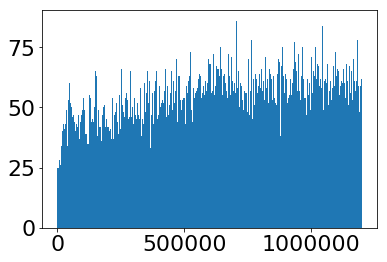

In [31]:
plt.hist(removals[:, -1], 30000000/30000)

(array([ 563.,  474.,  450.,  462.,  470.,  487.,  437.,  459.,  466.,
         456.,  478.,  481.,  475.,  455.,  479.,  440.,  462.,  480.,
         507.,  457.,  480.,  495.,  459.,  500.,  466.,  479.,  501.,
         474.,  501.,  490.,  495.,  486.,  508.,  522.,  549.,  523.,
         546.,  560.,  523.,  545.,  570.,  598.,  518.,  568.,  554.,
         601.,  556.,  578.,  579.,  572.,  586.,  611.,  601.,  633.,
         609.,  624.,  627.,  636.,  627.,  623.,  591.,  560.,  611.,
         586.,  656.,  589.,  593.,  611.,  561.,  559.,  615.,  612.,
         629.,  646.,  589.,  607.,  627.,  580.,  637.,  621.,  600.,
         630.,  610.,  639.,  571.,  637.,  614.,  627.,  614.,  581.,
         616.,  581.,  599.,  602.,  605.,  633.,  634.,  591.,  596.,  616.]),
 array([  1.11000000e+02,   1.21098600e+04,   2.41087200e+04,
          3.61075800e+04,   4.81064400e+04,   6.01053000e+04,
          7.21041600e+04,   8.41030200e+04,   9.61018800e+04,
          1.08100740e+05

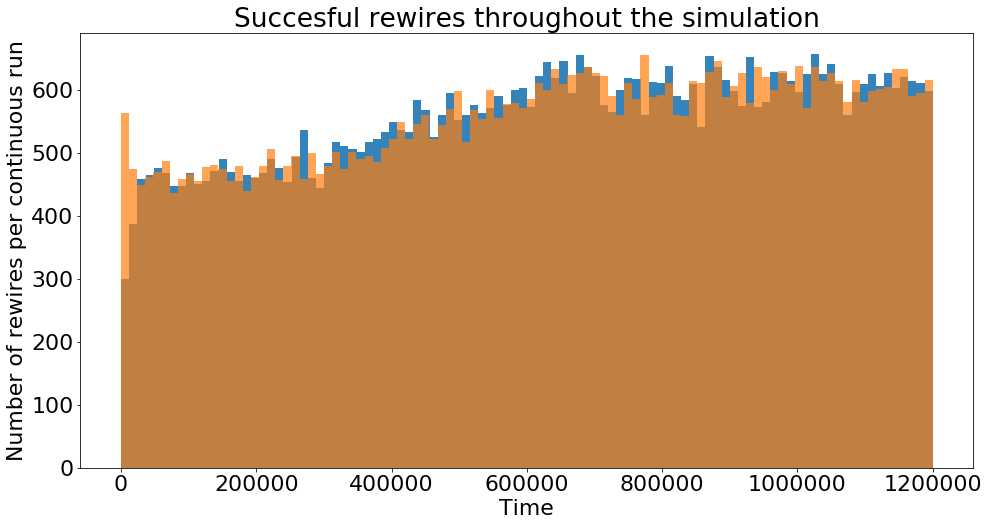

In [32]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Succesful rewires throughout the simulation")
ax1.set_ylabel("Number of rewires per continuous run")
ax1.set_xlabel("Time")
ax1.hist(removals[:, -1], int(3000000/30000), alpha=.9)
ax1.hist(formations[:, -1], int(3000000/30000), alpha=.7)

In [33]:
mlib.rcParams.update({'font.size': 20})

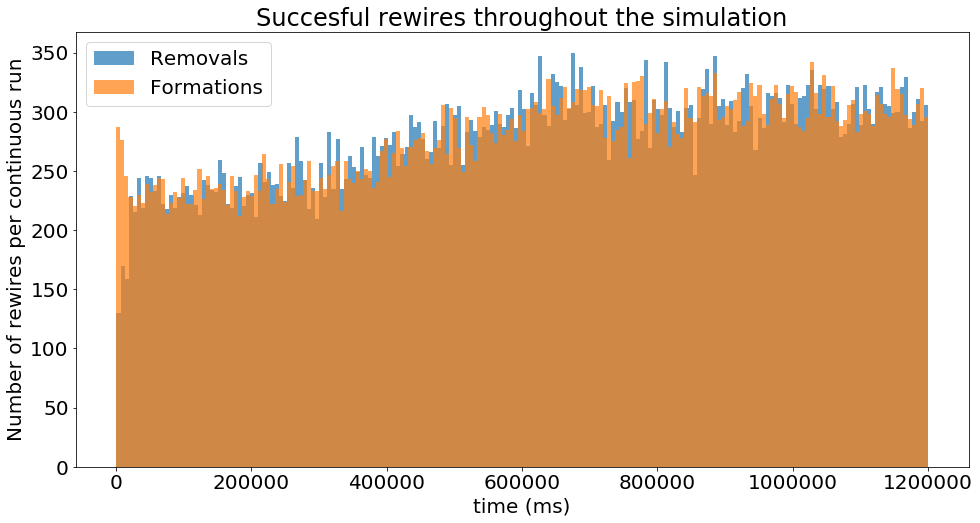

In [34]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8), dpi=600)
ax1.set_title("Succesful rewires throughout the simulation")
ax1.set_ylabel("Number of rewires per continuous run")
ax1.set_xlabel("time (ms)")
ax1.set_zorder(2)
# ax2 = ax1.twinx()
# ax2.set_ylabel("Number of failures per continuous run")
nr, binsr, patchesr = ax1.hist(removals[:, -1]  , int(600000/3000), alpha=.7, zorder=8, label="Removals")
nf, binsf, patchesf = ax1.hist(formations[:, -1], int(600000/3000), alpha=.7, zorder=9, label="Formations")
# ax2.hist(fail_times, int(3000000/30000),color='r', zorder=1, alpha=.7, label="Failures")
# ax2.set_zorder(1)

h1, l1 = ax1.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1, l1, loc='best')
plt.savefig('succesful_rewires.png')

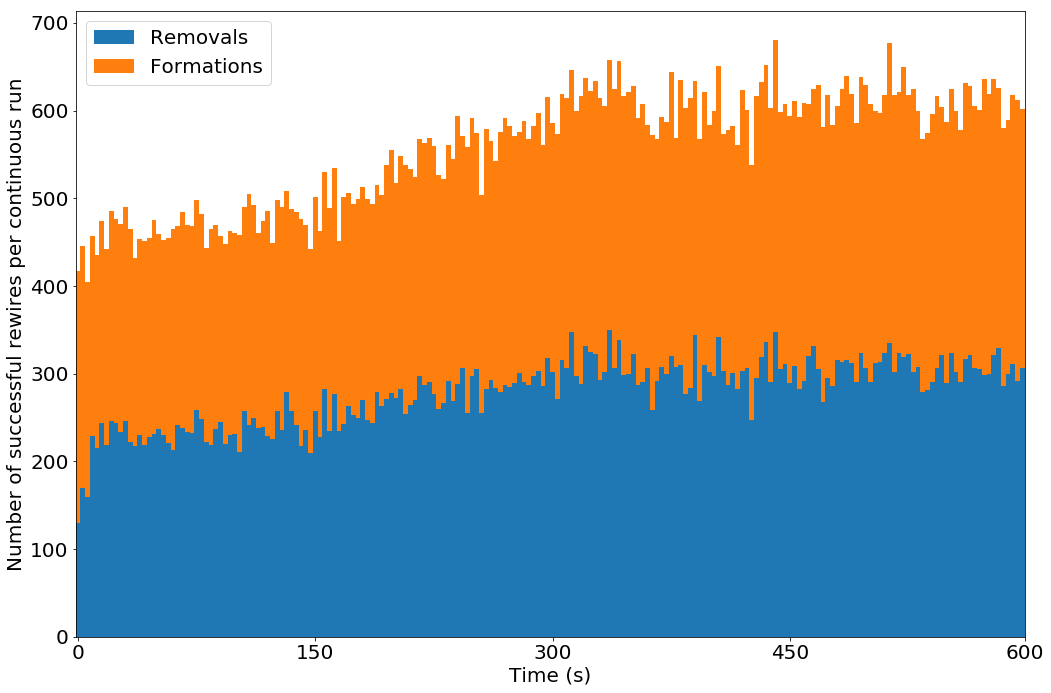

In [35]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(15, 10), dpi=600)
# ax1.set_title("Succesful rewires throughout the simulation")
ax1.set_ylabel("Number of successful rewires per continuous run")
ax1.set_xlabel("Time (s)")
ax1.set_zorder(2)
# ax2 = ax1.twinx()
# ax2.set_ylabel("Number of failures per continuous run")
w = 1.
ax1.bar(range(binsr.size-1),nr, label="Removals", width=w)#, color='#414C82')
ax1.bar(range(binsf.size-1),nf, label="Formations", bottom=nr, width=w)#, color='#A3DC37')
# ax2.hist(fail_times, int(3000000/30000),color='r', zorder=1, alpha=.7, label="Failures")
# ax2.set_zorder(1)

# ax1.set_xticklabels(((np.arange(binsf.size))-1)*200./3*second)
ax1.set_xticks([0, 50, 100, 150, 199.5])
ax1.set_xticklabels([0, 150, 300, 450, 600])
ax1.set_xlim([-.5, 199.5])
# ax1.set_ylim([0, 600])
h1, l1 = ax1.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1, l1, loc='best')

plt.tight_layout()
plt.savefig('succesful_rewires_stacked_barchart.png')